In [28]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import tensorflow as tf
import tensorflow_datasets as tfds 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

**Data Loading**

In [57]:
dataset, dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True)
# for data in dataset['train'].take(1):
#     print(data) 

In [58]:
dataset

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [31]:
#dataset_info

**Data Splitting**

In [32]:
def split(dataset,train_ratio,val_ratio,test_ratio):
    dataset_length=len(dataset)
    
    train_data=dataset.take(int(train_ratio*dataset_length))
    
    val_test_data=dataset.skip(int(train_ratio*dataset_length))
    
    val_data=val_test_data.take(int(val_ratio*dataset_length))
    
    test_data=val_test_data.skip(int(val_ratio*dataset_length))
    
    return train_data,val_data,test_data

In [33]:
TRAIN_RATIO=0.6
VAL_RATIO=0.2
TEST_RATIO=0.2

In [59]:
#dummy=tf.data.Dataset.range(10)
train_dataset,val_dataset,test_dataset=split(dataset['train'],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()))  
# print(list(val_dataset.take(1).as_numpy_iterator()))   
# print(list(test_dataset.take(1).as_numpy_iterator()))
'''as_numpy_iterator: Converts TF Tensors into regular NumPy
list: Collects all the values from the iterator into a list'''

'as_numpy_iterator: Converts TF Tensors into regular NumPy\nlist: Collects all the values from the iterator into a list'

**Data Visualization**

2025-04-22 19:18:18.713659: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


'On each iteration, image=train_dataset.image and label=train_dataset.label'

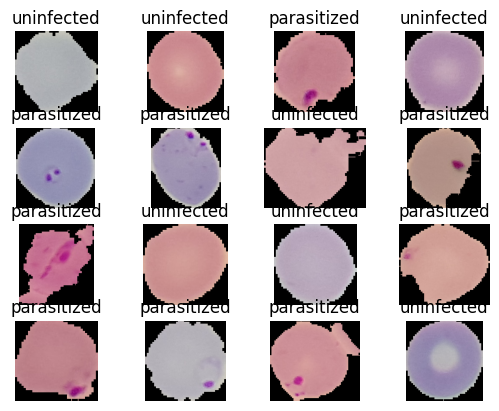

In [35]:
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label)) #converts numeric value in coresponding class name
    plt.axis("off")
'''On each iteration, image=train_dataset.image and label=train_dataset.label'''

**Data Processing**

*Image Resizing*

In [36]:
IM_SIZE=224
def resizing_rescale(image,label):
    return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255 , label


In [60]:
train_dataset=train_dataset.map(resizing_rescale)
val_dataset=val_dataset.map(resizing_rescale)
test_dataset=test_dataset.map(resizing_rescale)

In [61]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [39]:
# for image,label in train_dataset.take(1):
#     print(image,label)

*Prefetch Processing*
- buffer_size=8: Data is shuffled by taking one element of every 8 buffer,
- reshuffle_each_iteration=True: Reshufling will be done on each iteration
- batch(32): dataset will be divided into 32 batch
- prefetch(tf.data.AUTOTUNE): while working with one batch, another batch will be loaded'''

In [40]:
BATCH_SIZE=128
train_dataset=train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(train_dataset)
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


**Convulutional Neural Network**

**Model Creation**

In [41]:
'''Wo=(Wi-F+2P)S + 1
Wo=Output Size
Wi=Input Size
P=Padding
F=Kernel size
S=Stride
'''

'Wo=(Wi-F+2P)S + 1\nWo=Output Size\nWi=Input Size\nP=Padding\nF=Kernel size\nS=Stride\n'

In [42]:
lenet_model=Sequential([
    InputLayer(shape = (IM_SIZE,IM_SIZE,3)),
    
    Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2),strides=2),
    
    Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2),strides=2),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
    ])

# lenet_model.summary()
# tf.keras.utils.plot_model(lenet_model,"model.png",True)

In [43]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy,
              metrics=['accuracy']
              )

*Model Training*

In [44]:
history= lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.6987 - loss: 0.5899 - val_accuracy: 0.4986 - val_loss: 2.8882
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.8753 - loss: 0.3091 - val_accuracy: 0.4992 - val_loss: 1.9949
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.9041 - loss: 0.2542 - val_accuracy: 0.8086 - val_loss: 0.6062
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.9367 - loss: 0.1696 - val_accuracy: 0.8400 - val_loss: 0.4031
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.9456 - loss: 0.1461 - val_accuracy: 0.8715 - val_loss: 0.2964
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.9548 - loss: 0.1258 - val_accuracy: 0.9154 - val_loss: 0.2525
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.9593 - loss: 0.1070 - val_accuracy: 0.8969 - val_loss: 0.3496
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.9684 - loss: 0

**Performance Visualization**

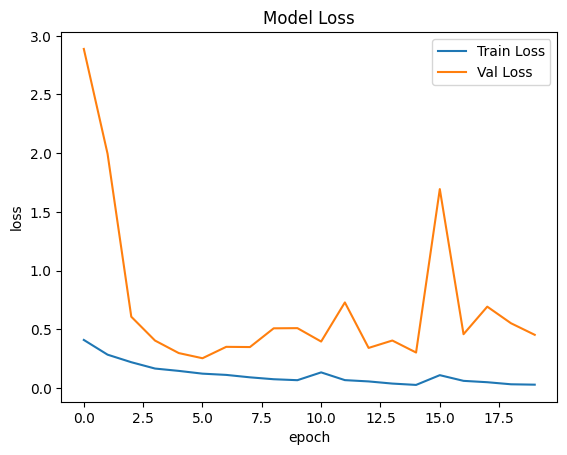

In [45]:
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model Loss')
plt.legend()
plt.show()

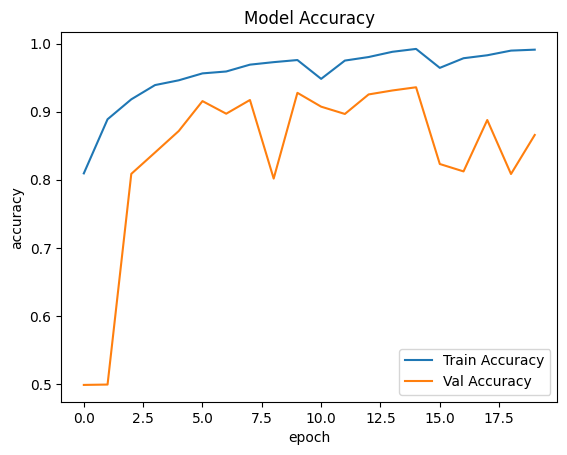

In [46]:
plt.plot(history.history['accuracy'],label="Train Accuracy")
plt.plot(history.history['val_accuracy'],label="Val Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

**Model Evaluation**

In [ ]:
#test_dataset=test_dataset.batch(1)

In [62]:
lenet_model.evaluate(test_dataset.take(100))

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [65]:
result=lenet_model.predict(test_dataset.batch(1).take(1)) #predicts the result of batch 1 (128 images) and returns an array consisting result of that 128 images
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(1, 1)

In [ ]:
def parasite_or_not(x):
    if(x<0.5):
        return str('P')
    else:
        return str('U')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


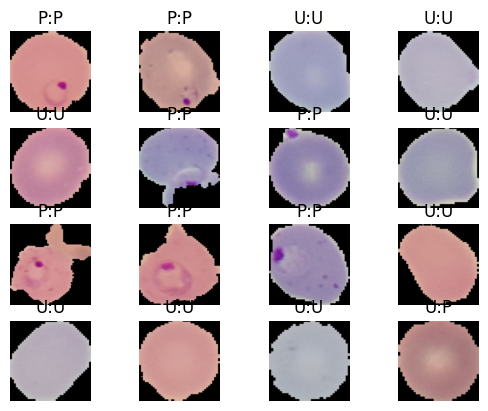

In [91]:
for i, (image,label) in enumerate(test_dataset.batch(1).take(16)):
    plt.subplot(4,4,i+1)
    
    plt.imshow(image[0])
    plt.axis("off")
    plt.title(str(parasite_or_not(label.numpy()[0]))+":"+str(parasite_or_not(lenet_model.predict(image)[0])))
    

In [ ]:
for i, (image,label) in enumerate(test_dataset.batch(1).take(5)):
    #print(image[0]) #image of test_dataset.batch(1).take(1) is a 4D tensor, to select the image value , image[0]
    print(label.numpy()[0]) #need to convert tensor to numpy array then selecting the 1st element of the np-array

0
0
1
1
0
